# Análisis de Datos de E-commerce con Prueba A/B y Clustering No Supervisado

Evaluar diferencias en ingresos mediante una prueba A/B simulada y segmentar clientes con KMeans para analizar patrones de comportamiento.

Este proyecto utiliza datos públicos del dataset "Online Retail" para llevar a cabo:
- Una **prueba A/B** simulada sobre ingresos promedio por grupo.
- Un análisis de **clustering no supervisado (KMeans)** sobre comportamiento de clientes.

In [16]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats

# Configuraciones generales
sns.set(style='whitegrid')


In [17]:

# Cargar datos desde CSV (convertido previamente desde Excel)
df = pd.read_excel("D:\\Daniel\\Estudio Virtual\\TRIPLETEN\\Proyectos\\1\\Online Retail.xlsx", parse_dates=["InvoiceDate"])
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [19]:
df.dropna(subset=['CustomerID'], inplace=True)  # Eliminar filas sin CustomerID
df['CustomerID'] = df['CustomerID'].astype(int)  # Convertir CustomerID a entero

In [20]:

# Ingresos por factura
df['TotalPrice'] = df['UnitPrice'] * df['Quantity']
df = df[df['TotalPrice'] > 0]


In [21]:

# Simulación de prueba A/B
clientes = df['CustomerID'].dropna().unique()
np.random.seed(42)
grupo_A = np.random.choice(clientes, size=len(clientes)//2, replace=False)
df['Grupo'] = df['CustomerID'].apply(lambda x: 'A' if x in grupo_A else 'B')

# Promedios por grupo
ingresos_A = df[df['Grupo'] == 'A'].groupby('InvoiceNo')['TotalPrice'].sum()
ingresos_B = df[df['Grupo'] == 'B'].groupby('InvoiceNo')['TotalPrice'].sum()

# Prueba t-test
t_stat, p_val = stats.ttest_ind(ingresos_A, ingresos_B, equal_var=False)
print(f"Estadístico t: {t_stat:.4f}, p-valor: {p_val:.4f}")


Estadístico t: -2.2247, p-valor: 0.0261


In [22]:

# RFM - Recency, Frequency, Monetary
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'}).dropna()

# Escalado y clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)
kmeans = KMeans(n_clusters=4, random_state=1)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm.head()


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346,326,1,77183.60,2
12347,2,7,4310.00,0
12348,75,4,1797.24,0
12349,19,1,1757.55,0
12350,310,1,334.40,1


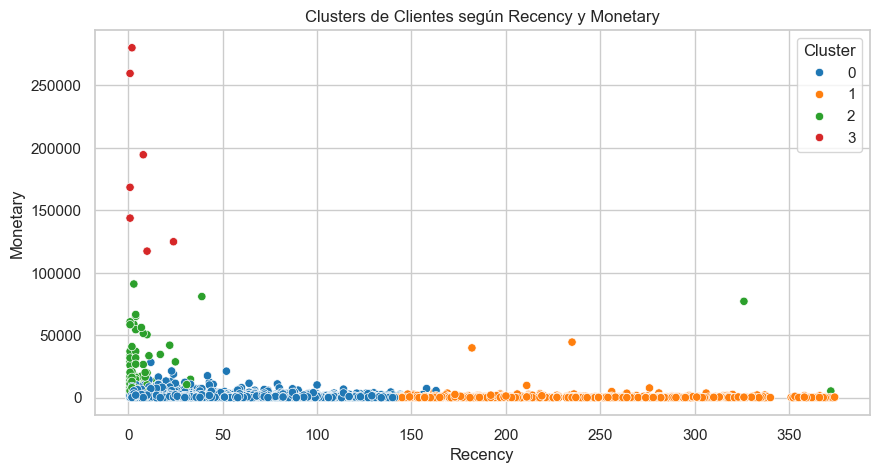

In [23]:

# Visualización de clusters
plt.figure(figsize=(10, 5))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='tab10')
plt.title("Clusters de Clientes según Recency y Monetary")
plt.show()



## Conclusiones

- **Prueba A/B:** El p-valor indica si existen diferencias significativas entre los grupos A y B en términos de ingresos promedio. Si p < 0.05, la diferencia es estadísticamente significativa.
- **Clustering:** El análisis RFM permitió segmentar a los clientes en 4 grupos distintos. Esto permite a marketing diseñar campañas más efectivas según el comportamiento de cada grupo.

Este análisis muestra cómo los datos transaccionales pueden usarse para tomar decisiones basadas en evidencias tanto en pruebas controladas como en segmentación de mercado.
